In [36]:
import os
from pathlib import Path
import math

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df, show_pathways_in_ranked_genes
from dokdonia.utils import terminal_execute

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results_DS2_Z"
data_dir = root_dir / "data"

In [2]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


In [3]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


In [4]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


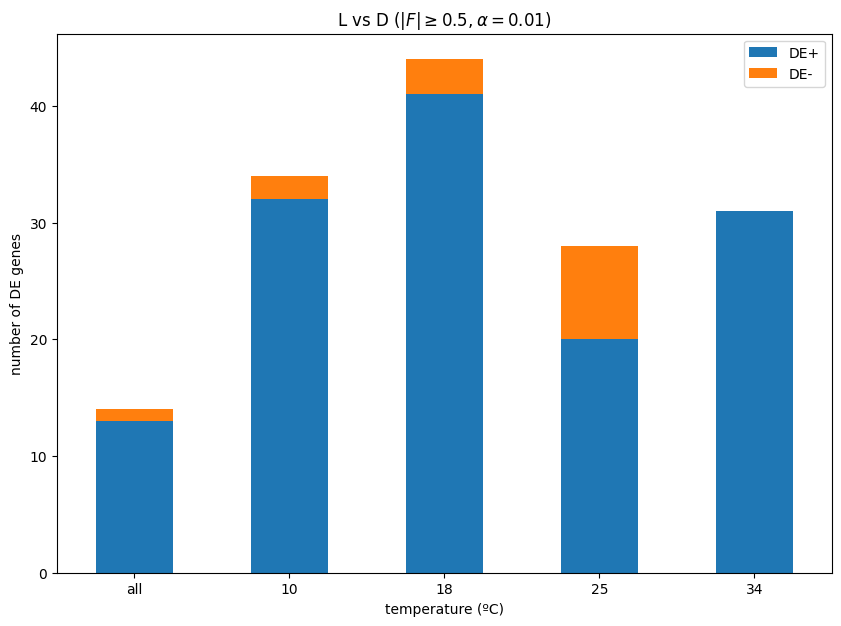

In [5]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [6]:
DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }

In [7]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes which are DE across all temperature values


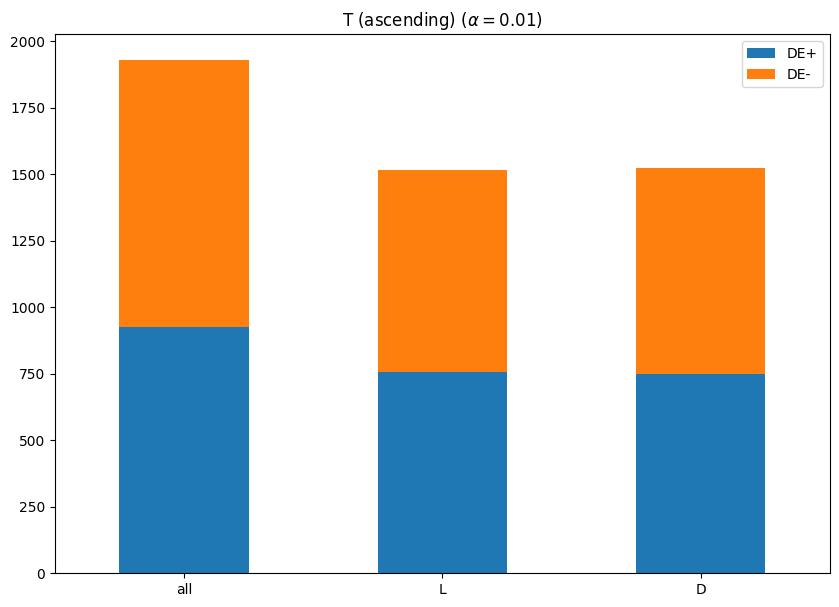

In [8]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

## Load TC

In [9]:
# Get transcript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

In [10]:
# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) &
    (TC.index.isin(DE_genes_across_T))
    )]

## Remove light/dark DE genes

In [11]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) &
    (counts["index"].isin(DE_genes_across_T))
    )]

# Remove outlier D_18
TC_no18 = TC.drop(columns=[col for col in TC.columns if 'D_18' in col])
TC_no18_noDE = TCnoDE.drop(columns=[col for col in TCnoDE.columns if 'D_18' in col])

In [12]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts_noDE.columns, 'Temperature': counts_noDE.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts_noDE = DE.deseq2Normalize(counts_noDE, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

deseq2_counts_noDE = deseq2_counts_noDE.drop("index", axis=1)

INFO:DESeq2:Normalizing counts


## Find clusters


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Tuesday 09 May 2023 (11:06:46)                       |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

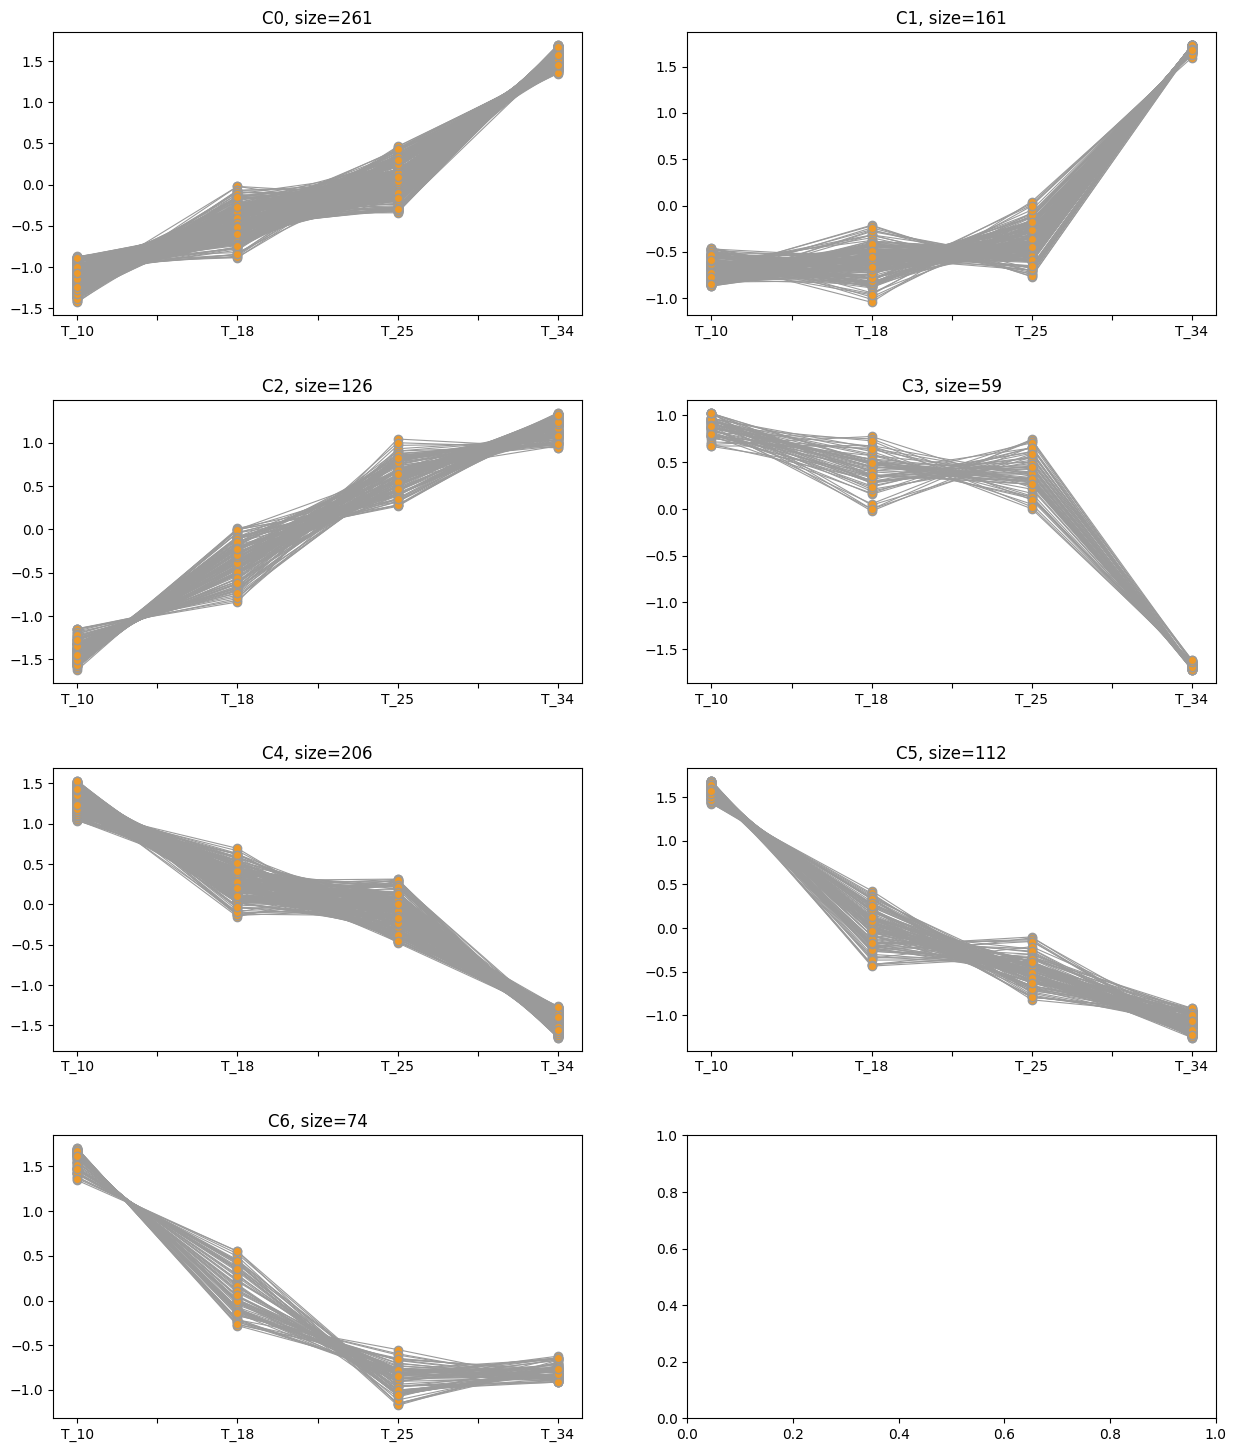

In [13]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ONLY_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2_only_zscores = CA.getGeneClusters(deseq2_counts_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization_only_zscores.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data_only_zscores = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data_only_zscores, clusters_DS2_only_zscores)

There are a total of 999 clustered genes


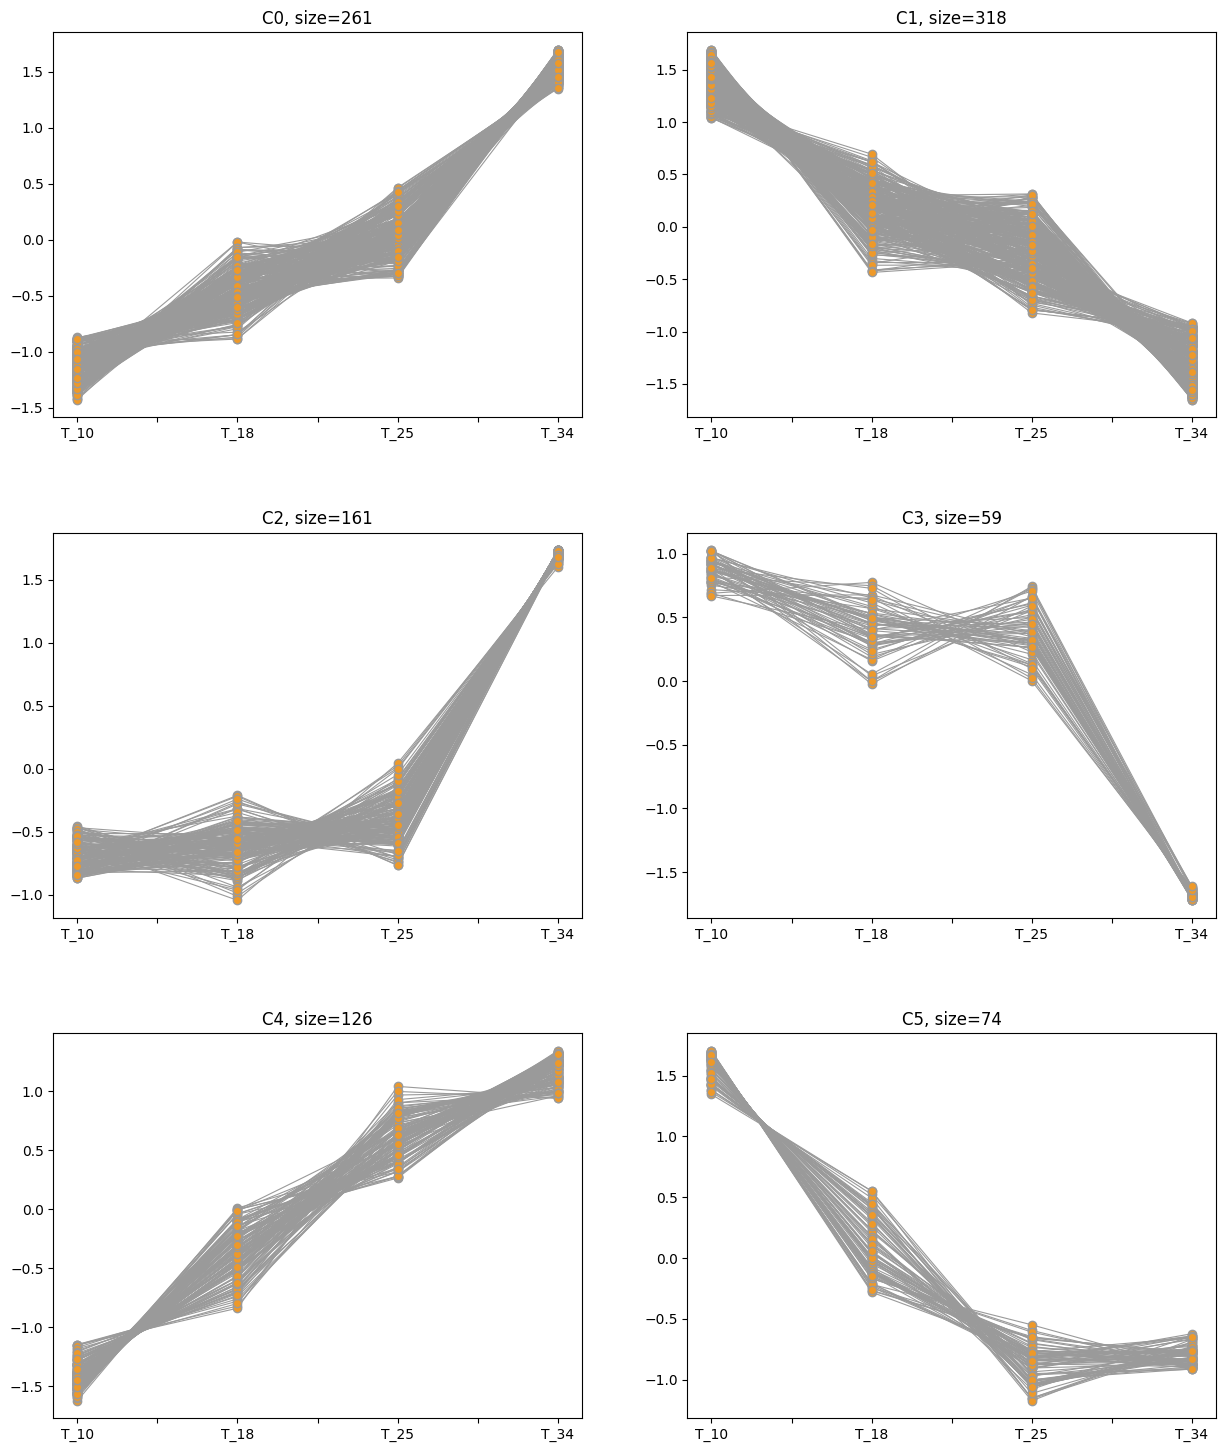

In [14]:
# Merge clusters
clusters_DS2_only_zscores = {
    "C0": clusters_DS2_only_zscores["C0"],
    "C1": clusters_DS2_only_zscores["C4"] + clusters_DS2_only_zscores["C5"],
    "C2": clusters_DS2_only_zscores["C1"],
    "C3": clusters_DS2_only_zscores["C3"],
    "C4": clusters_DS2_only_zscores["C2"],
    "C5": clusters_DS2_only_zscores["C6"]
}


# Merge clusters in Clust output file
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters_DS2_only_zscores.items() ]))
df = df.applymap(lambda x: "" if pd.isna(x) else x)

with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
    file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters_DS2_only_zscores.items()]) + "\n")
    file.write("\t".join(["Genes" for _ in clusters_DS2_only_zscores]) + "\n")

    for row in df.values:
        file.write("\t".join(row) + "\n")

n_genes_in_clusters = sum([len(c) for c in clusters_DS2_only_zscores.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

VI.plotClusters(plot_cluster_data_only_zscores, clusters_DS2_only_zscores)

## Plot cluster Deseq2 values alongside TC

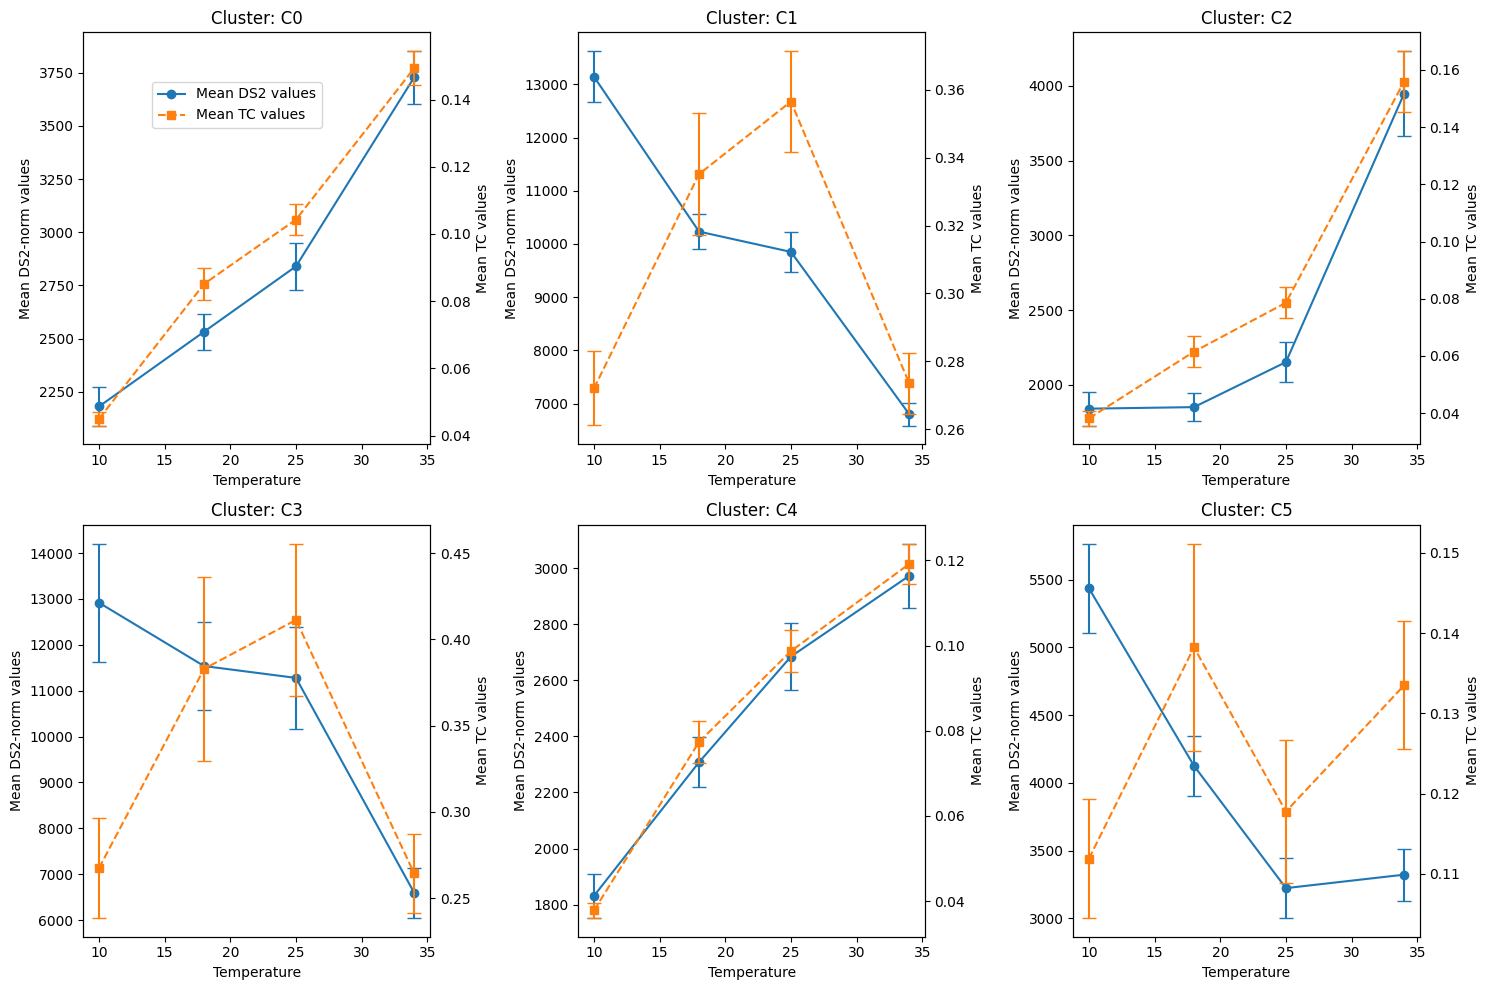

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

temperatures = [10, 18, 25, 34]
clusters = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

for idx, cluster in enumerate(clusters):
    marker_genes = [gene for gene in clusters_DS2_only_zscores[cluster]]
    df = deseq2_counts_noDE.loc[marker_genes, :]
    df_TC = TC_no18.loc[marker_genes, :]

    df_long = df.melt(var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    df_long_TC = df_TC.melt(var_name='Column', value_name='Value')
    df_long_TC['Temperature'] = df_long_TC['Column'].str.extract('_(\d+)_')
    df_long_TC['Temperature'] = pd.to_numeric(df_long_TC['Temperature'])

    grouped = df_long.groupby('Temperature')['Value']
    mean_values = grouped.mean()
    standard_error_values = grouped.sem()

    grouped_TC = df_long_TC.groupby('Temperature')['Value']
    mean_values_TC = grouped_TC.mean()
    standard_error_values_TC = grouped_TC.sem()

    # Plot the mean values for deseq2_counts_noDE
    l1 = axs[idx].plot(mean_values.index, mean_values, marker='o', linestyle='-', color='C0', label='Mean DS2 values')

    # Add error bars for the standard errors for deseq2_counts_noDE
    axs[idx].errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, color='C0', label='SDE DS2 values')

    # Create secondary y-axis for TC data
    ax2 = axs[idx].twinx()

    # Plot the mean values for TC
    l2 = ax2.plot(mean_values_TC.index, mean_values_TC, marker='s', linestyle='--', color='C1', label='Mean TC values')

    # Add error bars for the standard errors for TC
    ax2.errorbar(mean_values_TC.index, mean_values_TC, yerr=standard_error_values_TC, linestyle='', capsize=5, color='C1', label='SDE TC values')

    # Customize the plot
    axs[idx].set_xlabel('Temperature')
    axs[idx].set_ylabel('Mean DS2-norm values')
    ax2.set_ylabel('Mean TC values')
    axs[idx].set_title(f'Cluster: {cluster}')

    # Collect legend handles and labels
    if idx == 0:
        legend_handles.extend(l1 + l2)
        legend_labels.extend([h.get_label() for h in l1 + l2])

# Adjust the layout of the subplots
plt.tight_layout()

# Add a single legend for the whole figure
fig.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(0.1, 0.92))

# Show the plot
plt.savefig('paper_figures/deseq2_counts__Z_noDE_TC_clusters.png')
plt.savefig('paper_figures/deseq2_counts_Z_noDE_TC_clusters.eps', format='eps', dpi=1000)
plt.show()


## Plot Deseq2 and TC values for all genes in clusters

In [30]:
output_dir = Path("deseq2_Zscores_TC_figs")
if not output_dir:
    output_dir.mkdir(parents=True)


def plot_gene_expression(
        ax, gene_id, gene_name, mean_values, standard_error_values,
        mean_values_TC, standard_error_values_TC, show_legend=False
        ):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values')
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values')
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='C1', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='C1', label='SDE TC values')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Mean DS2-norm Values')
    ax2.set_ylabel('Mean TC Values')
    ax.set_title(f'Gene: {gene_id} ({gene_name})')
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)


def plot_and_save_gene(
        gene_id, gene_name, mean_values_gene,
        standard_error_values_gene, mean_values_gene_TC,
        standard_error_values_gene_TC, show_legend=False,
        output_dir="deseq2_Zscores_TC_figs"
        ):
    fig, ax = plt.subplots(figsize=(5, 4))
    
    plot_gene_expression(
        ax, gene_id, gene_name, mean_values_gene,
        standard_error_values_gene, mean_values_gene_TC,
        standard_error_values_gene_TC, show_legend
        )

    plt.tight_layout()
    plt.savefig(f"deseq2_Zscores_TC_figs/{gene_id}_{gene_name}.png")
    plt.close(fig)


TC_data = TC_no18
target_genes = [gene for cluster in clusters_DS2_only_zscores.values() for gene in cluster]

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts_noDE.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC_data.loc[target_genes, :].reset_index().melt(id_vars='ID', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['ID', 'Temperature'])['Value']
mean_values_TC = grouped_TC.mean().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()


for cluster, genes in clusters_DS2_only_zscores.items():
    for idx, gene_id in enumerate(genes):
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['ID'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['ID'] == gene_id]
        show_legend = (idx == 0)
        
        plot_and_save_gene(
            cluster, gene_id, mean_values_gene,
            standard_error_values_gene, mean_values_gene_TC,
            standard_error_values_gene_TC, show_legend,
            output_dir=output_dir
            )


## Genes that don't follow the cluster pattern very well

In [ ]:
mismatches = {
    "C2": [
        "MED134_07099",  # huge error bar at 10ºC
    ],
    "C3": [
        "MED134_02020",  # looks more neg linear
        "MED134_04064",  # looks more neg linear
        "MED134_10690",  # looks more neg linear, large error bars
    ],
    "C4": [
        "MED134_00030",  # looks linear
        "MED134_01240",  # looks linear
    ]
}

In [16]:
light_marker_genes = [
    ("MED134_07119", ""),
    ("MED134_14266", "deoxyribodipyrimidine photo-lyase class I"),
    ("MED134_10201", "cryptochrome of the DASH family"),
    ("MED134_10206", "a deoxyribodipyrimidine photolyase-related protein"),
    ("MED134_10226", "Met sulfoxide reductase"),
]

dark_marker_genes = [
    ("MED134_06219", ""),
]


plot_marker_genes = {
    "C0": [
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
        ("MED134_09156","a lipoprotein with peptidase domains"),
        ("MED134_11471","periplasmic protein TonB"),
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_04959","preprotein translocase, YajC subunit"),
        ("MED134_00950","tetrahydrofolate synthase"),
        ("MED134_00060","dihydrofolate reductase"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
    ],
    "C1": [
        ("MED134_13806","GTP-binding elongation factor family protein TypA/BipA"),
        ("MED134_09221", "ribonuclease R"),
        ("MED134_14001", "peptidylprolyl isomerase"),
        ("MED134_11356", "translation initiation factor IF-2"),
    ],
    "C2": [
        ("MED134_01775","malate synthase"),
        ("MED134_06589", "serine hydroxymethyltransferase"),
        ("MED134_01780", "isocitrate lyase"),
        ("MED134_02735", "cytochrome c oxidase accessory protein CcoG"),
        ("MED134_08216", "catalase/peroxidase HPI"),
        ("MED134_14682", "cytochrome c peroxidase"),
        ("MED134_04044", "HSP20-like chaperone"),
        ("MED134_04049", "excinuclease ABC, B subunit"),
        ("MED134_02620", "universal stress protein UspA"),
        ("MED134_13486", "RNA polymerase sigma factor, sigma-70 family"),
        ("MED134_14121","TonB dependent/ligand-gated channel"),
        ("MED134_00210","TonB dependent/ligand-gated channel"),
        ("MED134_14136","TonB dependent/ligand-gated channel"),
        ("MED134_07224","TonB dependent/ligand-gated channel"),
        ("MED134_12646", "DNA primase"),
    ],
    "C3": [
        ("MED134_07436","TonB dependent/ligand-gated channel"),
        ("MED134_08871","metallopeptidase family M36"),
        ("MED134_02950","30S ribosomal protein S1"),
        ("MED134_00540","50S ribosomal protein L13"),
        ("MED134_02405","50S ribosomal protein L1"),
        ("MED134_14156", "prolyl-tRNA synthetase"),
        ("MED134_10865", "aspartyl-tRNA synthetase"),
        ("MED134_10865", "aspartyl-tRNA synthetase"),
        ("MED134_14191", "methionyl-tRNA formyltransferase"),
        ("MED134_02425","DNA-directed RNA polymerase beta' chain"),
        ("MED134_02420","DNA-directed RNA polymerase beta chain"),
        ("MED134_02395","transcriptional antitermination factor NusG"),
        ("MED134_01005","translation initiation factor IF-3"),
        ("MED134_01885", "DNA replication and repair protein RecF"),
        ("MED134_02225", "DNA polymerase III, epsilon subunit"),
    ],
    "C4": [
        ("MED134_06674","TonB dependent/ligand-gated channel"),
        ("MED134_00130","electron transfer flavoprotein beta-subunit"),
        ("MED134_00125","electron transfer flavoprotein alpha subunit"),
        ("MED134_06239","acyl-CoA dehydrogenase"),
        ("MED134_07726","methylmalonyl-CoA mutase large subunit"),
        ("MED134_07736","methylmalonyl-CoA mutase small subunit"),
        ("MED134_13066","beta-carotene hydroxylase"),
        ("MED134_07389","gliding motility protein"),
        ("MED134_05129", "TBDT with a carboxypeptidase domain"),
    ],
    "C5": [
        ("MED134_14787","alanine dehydrogenase"),
        ("MED134_11926","acetylornithine aminotransferase"),
        ("MED134_11941","acetylornithine deacetylase"),
        ("MED134_04309","homoserine kinase"),
        ("MED134_11936","acetylglutamate kinase"),
        ("MED134_11916","N-acetyl-gamma-glutamyl-phosphate reductase"),
        ("MED134_11921","pyrroline-5-carboxylate reductase"),

    ],
}

## Shared marker genes (TC and Deseq2 zscores clusters)

In [17]:
shared_genes, missing_genes = {}, {}
for cluster_id, cluster in clusters_DS2_only_zscores.items():
    marker_genes = [gene_id for gene_id, gene_name in plot_marker_genes[cluster_id]]
    genes_in_cluster = set(cluster).intersection(marker_genes)
    shared_genes[cluster_id] = genes_in_cluster
    missing_genes[cluster_id] = set(marker_genes).difference(cluster)
    print(f"Cluster: {cluster_id}\tTC Marker Genes in DS2 Cluster: {len(genes_in_cluster) / len(marker_genes) * 100:.2f}%")

Cluster: C0	TC Marker Genes in DS2 Cluster: 50.00%
Cluster: C1	TC Marker Genes in DS2 Cluster: 100.00%
Cluster: C2	TC Marker Genes in DS2 Cluster: 66.67%
Cluster: C3	TC Marker Genes in DS2 Cluster: 6.67%
Cluster: C4	TC Marker Genes in DS2 Cluster: 11.11%
Cluster: C5	TC Marker Genes in DS2 Cluster: 85.71%


In [18]:
shared_genes

{'C0': {'MED134_00950',
  'MED134_04959',
  'MED134_06494',
  'MED134_09156',
  'MED134_14141'},
 'C1': {'MED134_09221', 'MED134_11356', 'MED134_13806', 'MED134_14001'},
 'C2': {'MED134_00210',
  'MED134_01775',
  'MED134_01780',
  'MED134_02620',
  'MED134_02735',
  'MED134_04044',
  'MED134_06589',
  'MED134_07224',
  'MED134_08216',
  'MED134_13486'},
 'C3': {'MED134_02425'},
 'C4': {'MED134_13066'},
 'C5': {'MED134_11916',
  'MED134_11921',
  'MED134_11926',
  'MED134_11936',
  'MED134_11941',
  'MED134_14787'}}

In [19]:
missing_genes

{'C0': {'MED134_00060',
  'MED134_01190',
  'MED134_05219',
  'MED134_11471',
  'MED134_12046'},
 'C1': set(),
 'C2': {'MED134_04049',
  'MED134_12646',
  'MED134_14121',
  'MED134_14136',
  'MED134_14682'},
 'C3': {'MED134_00540',
  'MED134_01005',
  'MED134_01885',
  'MED134_02225',
  'MED134_02395',
  'MED134_02405',
  'MED134_02420',
  'MED134_02950',
  'MED134_07436',
  'MED134_08871',
  'MED134_10865',
  'MED134_14156',
  'MED134_14191'},
 'C4': {'MED134_00125',
  'MED134_00130',
  'MED134_05129',
  'MED134_06239',
  'MED134_06674',
  'MED134_07389',
  'MED134_07726',
  'MED134_07736'},
 'C5': {'MED134_04309'}}

# Annotate and rank genes within clusters

In [20]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ONLY_ZSCORES"

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col="Unnamed: 0")
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_DS2_only_zscores, cluster_data, method="median")

In [21]:
(results_dir / "pathways").mkdir(exist_ok=True)

no_kegg_pathway = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")

print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[83.9080459770115, 63.522012578616355, 85.09316770186335, 66.10169491525424, 81.74603174603175, 74.32432432432432]
75.78254620718359


## Ranked lists among the global 10% by expression

In [22]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} Deseq2 values")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 13537.398557651415 Deseq2 values


# Gene set enrichment with R

KEGG subsystems

### Original clusters

In [31]:
out_dir = results_dir / "enrichment_results"
out_dir.mkdir(exist_ok=True)

clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)


clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter



In [33]:
# Using R's library ClusterProfiler
df = pd.read_csv(results_dir / f"enrichment_results/results_{res_id}.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df = df.sort_values(["Cluster", "p.adjust"])
res_df = df[["Cluster", "ID", "Description", "GeneRatio", "pvalue", "p.adjust"]].set_index("Cluster")
res_df.to_csv(results_dir / "enrichment_results" / "original_cluster_pathways.csv")
res_df

,ID,Description,GeneRatio,pvalue,p.adjust
Cluster,,,,,
C4,dok03010,Ribosome - Dokdonia sp. MED134,35/87,8.104318e-12,2.755468e-10
C4,dok00970,Aminoacyl-tRNA biosynthesis - Dokdonia sp. MED134,9/87,1.666989e-03,2.833882e-02
C5,dok03018,RNA degradation - Dokdonia sp. MED134,5/31,1.962176e-03,5.297874e-02
C6,dok00220,Arginine biosynthesis - Dokdonia sp. MED134,7/19,3.668092e-08,7.702994e-07
C6,dok01230,Biosynthesis of amino acids - Dokdonia sp. MED134,9/19,1.747199e-05,1.834559e-04
C6,dok01210,2-Oxocarboxylic acid metabolism - Dokdonia sp....,5/19,1.602046e-04,1.121432e-03
C6,dok00250,"Alanine, aspartate and glutamate metabolism - ...",5/19,5.318747e-04,2.792342e-03
C6,dok01110,Biosynthesis of secondary metabolites - Dokdon...,11/19,2.346490e-03,9.855259e-03
C6,dok01100,Metabolic pathways - Dokdonia sp. MED134,15/19,2.269279e-02,7.942478e-02


### Merged clusters

In [34]:
out_dir = results_dir / "enrichment_results"
out_dir.mkdir(exist_ok=True)

clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects_merged.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)


clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter



In [35]:
# Using R's library ClusterProfiler
df = pd.read_csv(results_dir / f"enrichment_results/results_{res_id}.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df = df.sort_values(["Cluster", "p.adjust"])
res_df = df[["Cluster", "ID", "Description", "GeneRatio", "pvalue", "p.adjust"]].set_index("Cluster")
res_df.to_csv(results_dir / "enrichment_results" / "merged_cluster_pathways.csv")
res_df

,ID,Description,GeneRatio,pvalue,p.adjust
Cluster,,,,,
C1,dok03010,Ribosome - Dokdonia sp. MED134,37/118,1.230307e-08,4.429104e-07
C1,dok00970,Aminoacyl-tRNA biosynthesis - Dokdonia sp. MED134,10/118,3.120751e-03,5.617351e-02
C5,dok00220,Arginine biosynthesis - Dokdonia sp. MED134,7/19,3.668092e-08,7.702994e-07
C5,dok01230,Biosynthesis of amino acids - Dokdonia sp. MED134,9/19,1.747199e-05,1.834559e-04
C5,dok01210,2-Oxocarboxylic acid metabolism - Dokdonia sp....,5/19,1.602046e-04,1.121432e-03
C5,dok00250,"Alanine, aspartate and glutamate metabolism - ...",5/19,5.318747e-04,2.792342e-03
C5,dok01110,Biosynthesis of secondary metabolites - Dokdon...,11/19,2.346490e-03,9.855259e-03
C5,dok01100,Metabolic pathways - Dokdonia sp. MED134,15/19,2.269279e-02,7.942478e-02


# Plotting genes mentioned in the paper

Some of them not included in the new clusters (made only with Zscores), however the pattern still holds.

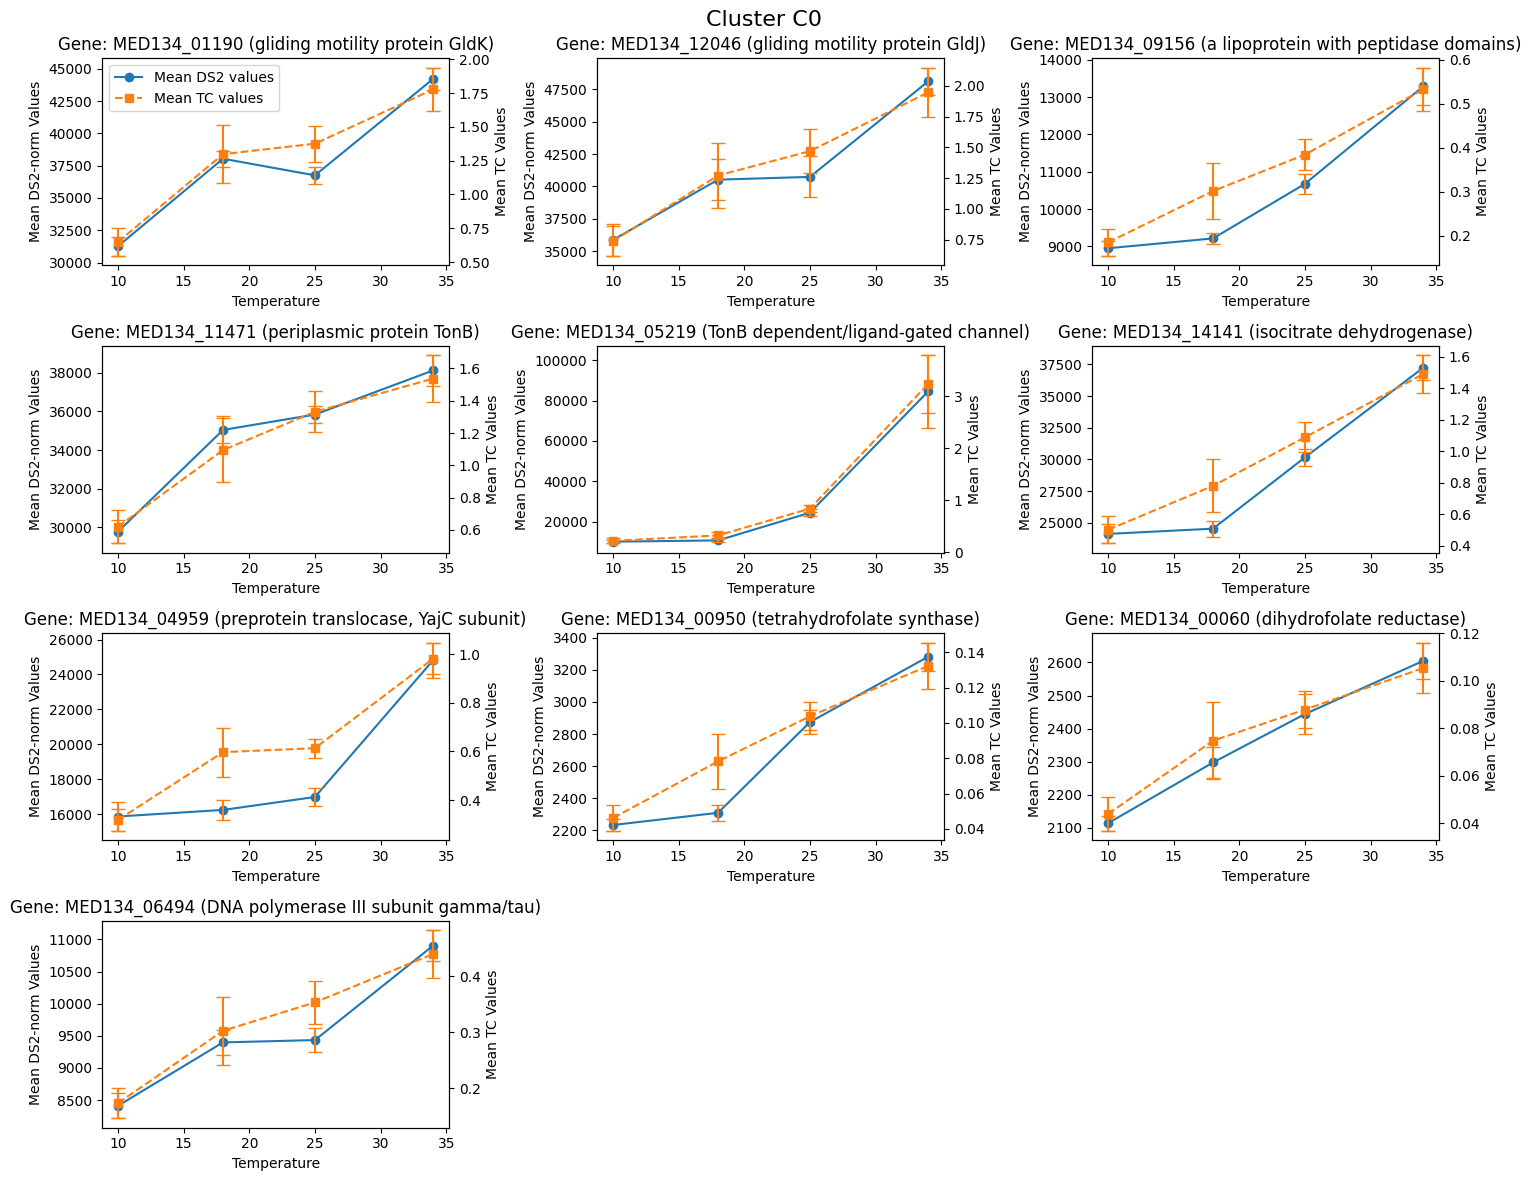

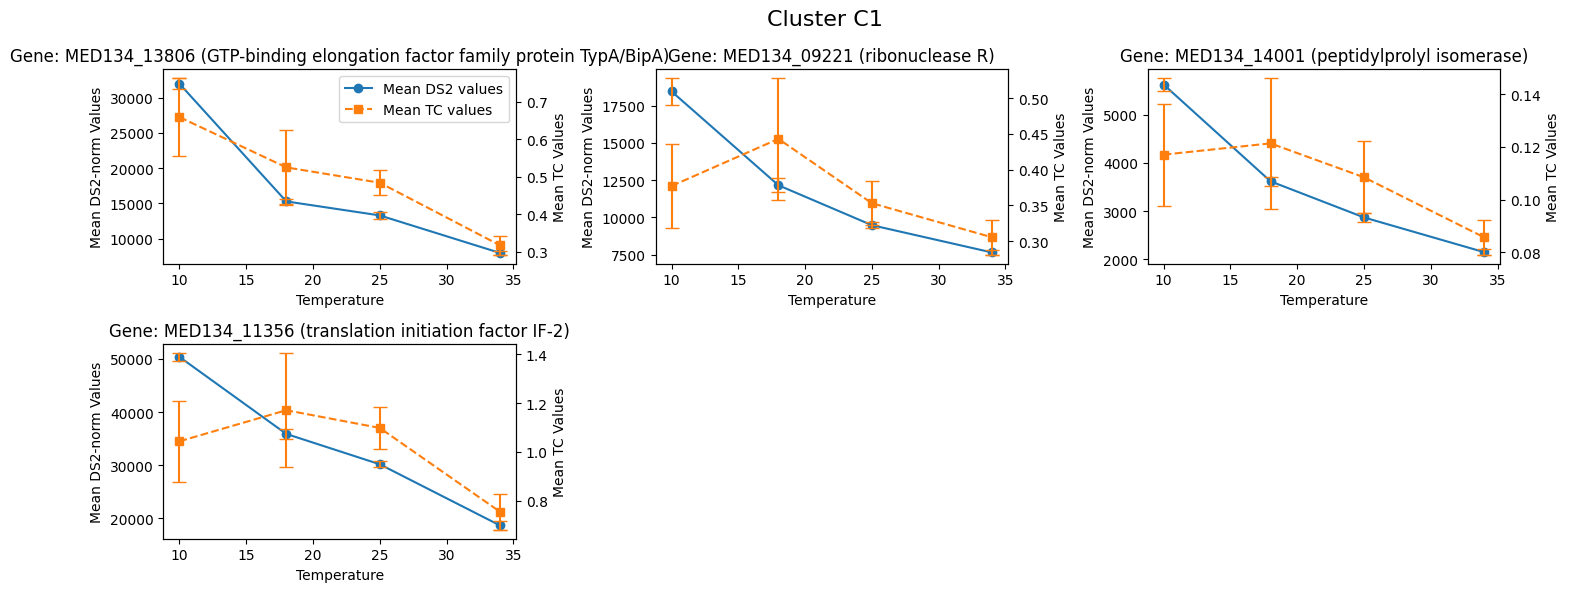

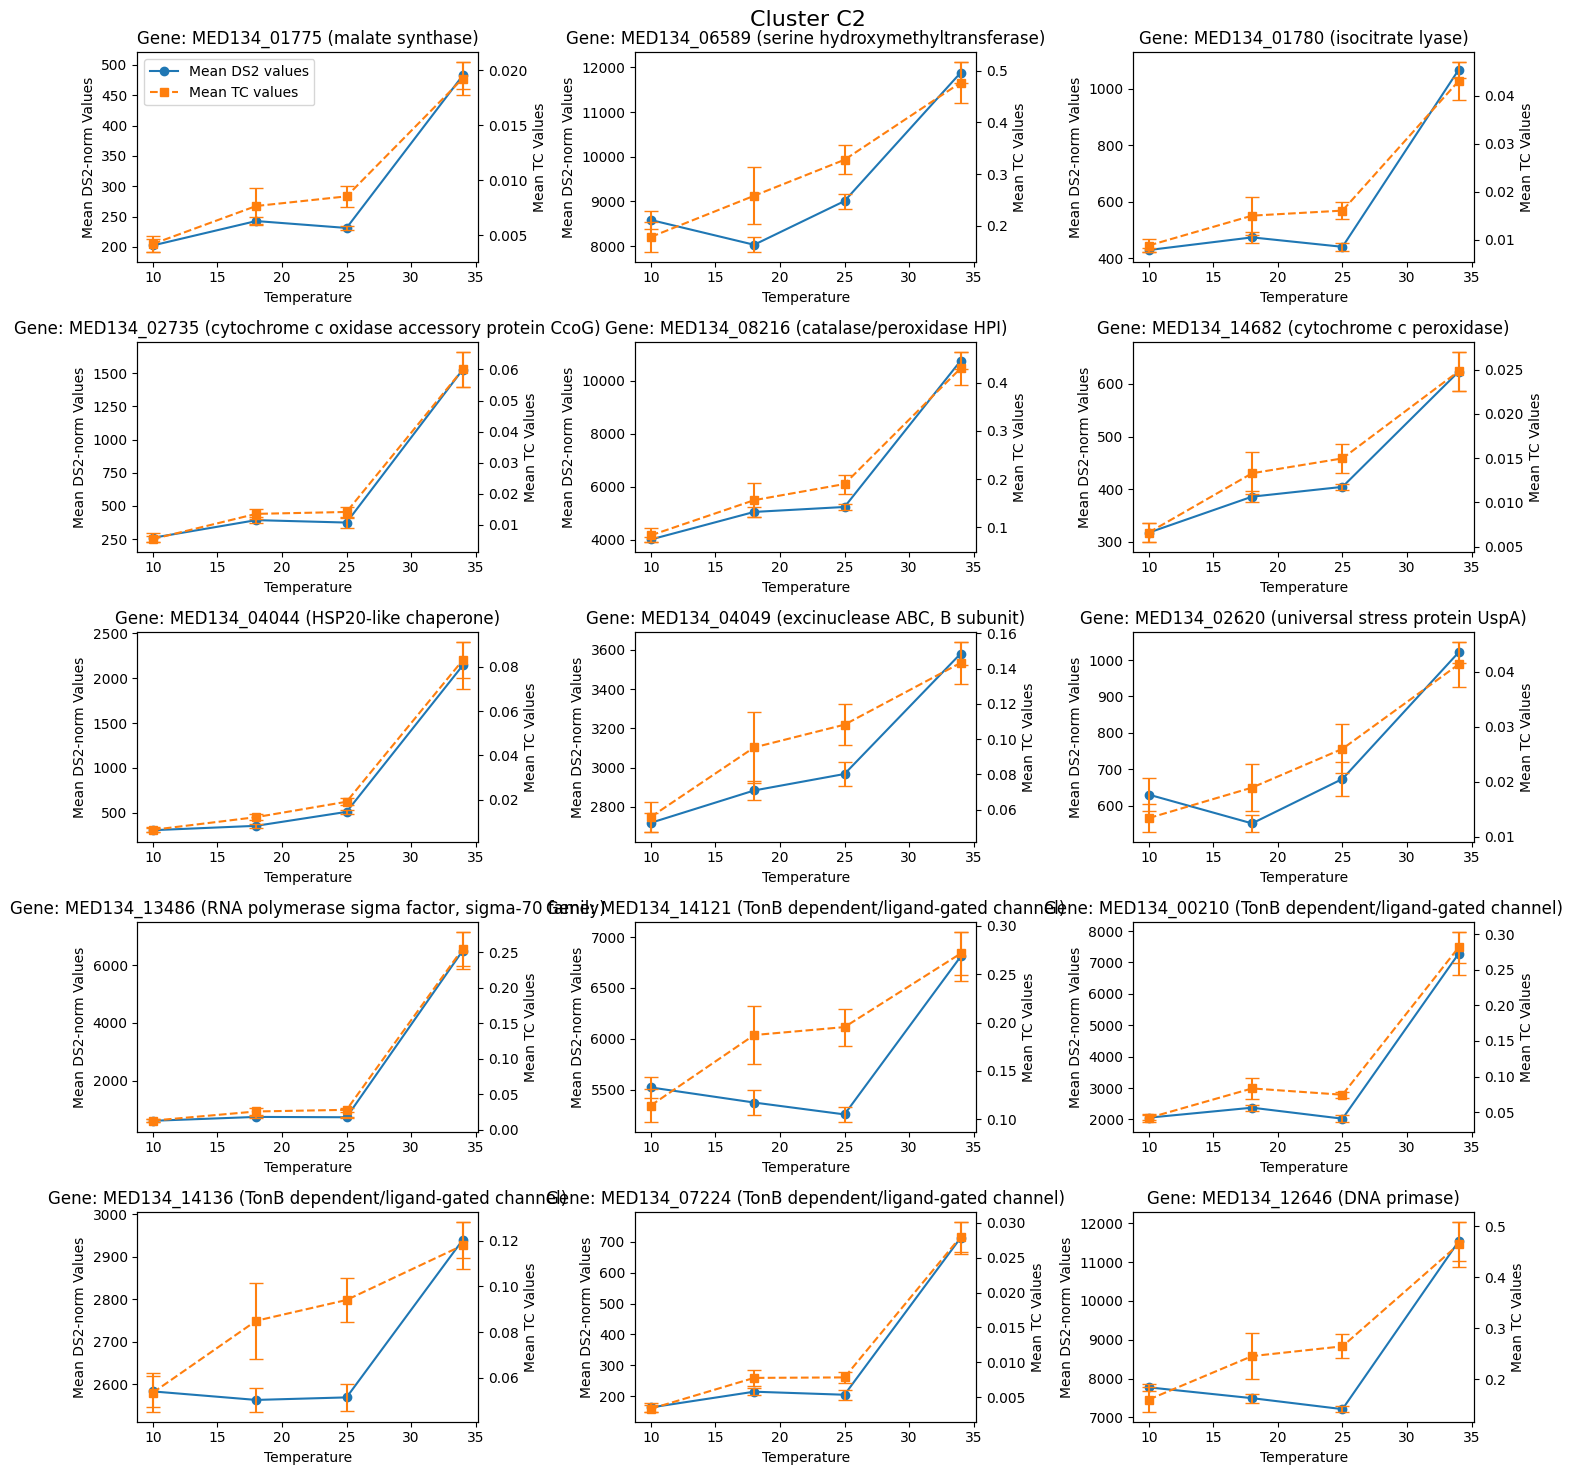

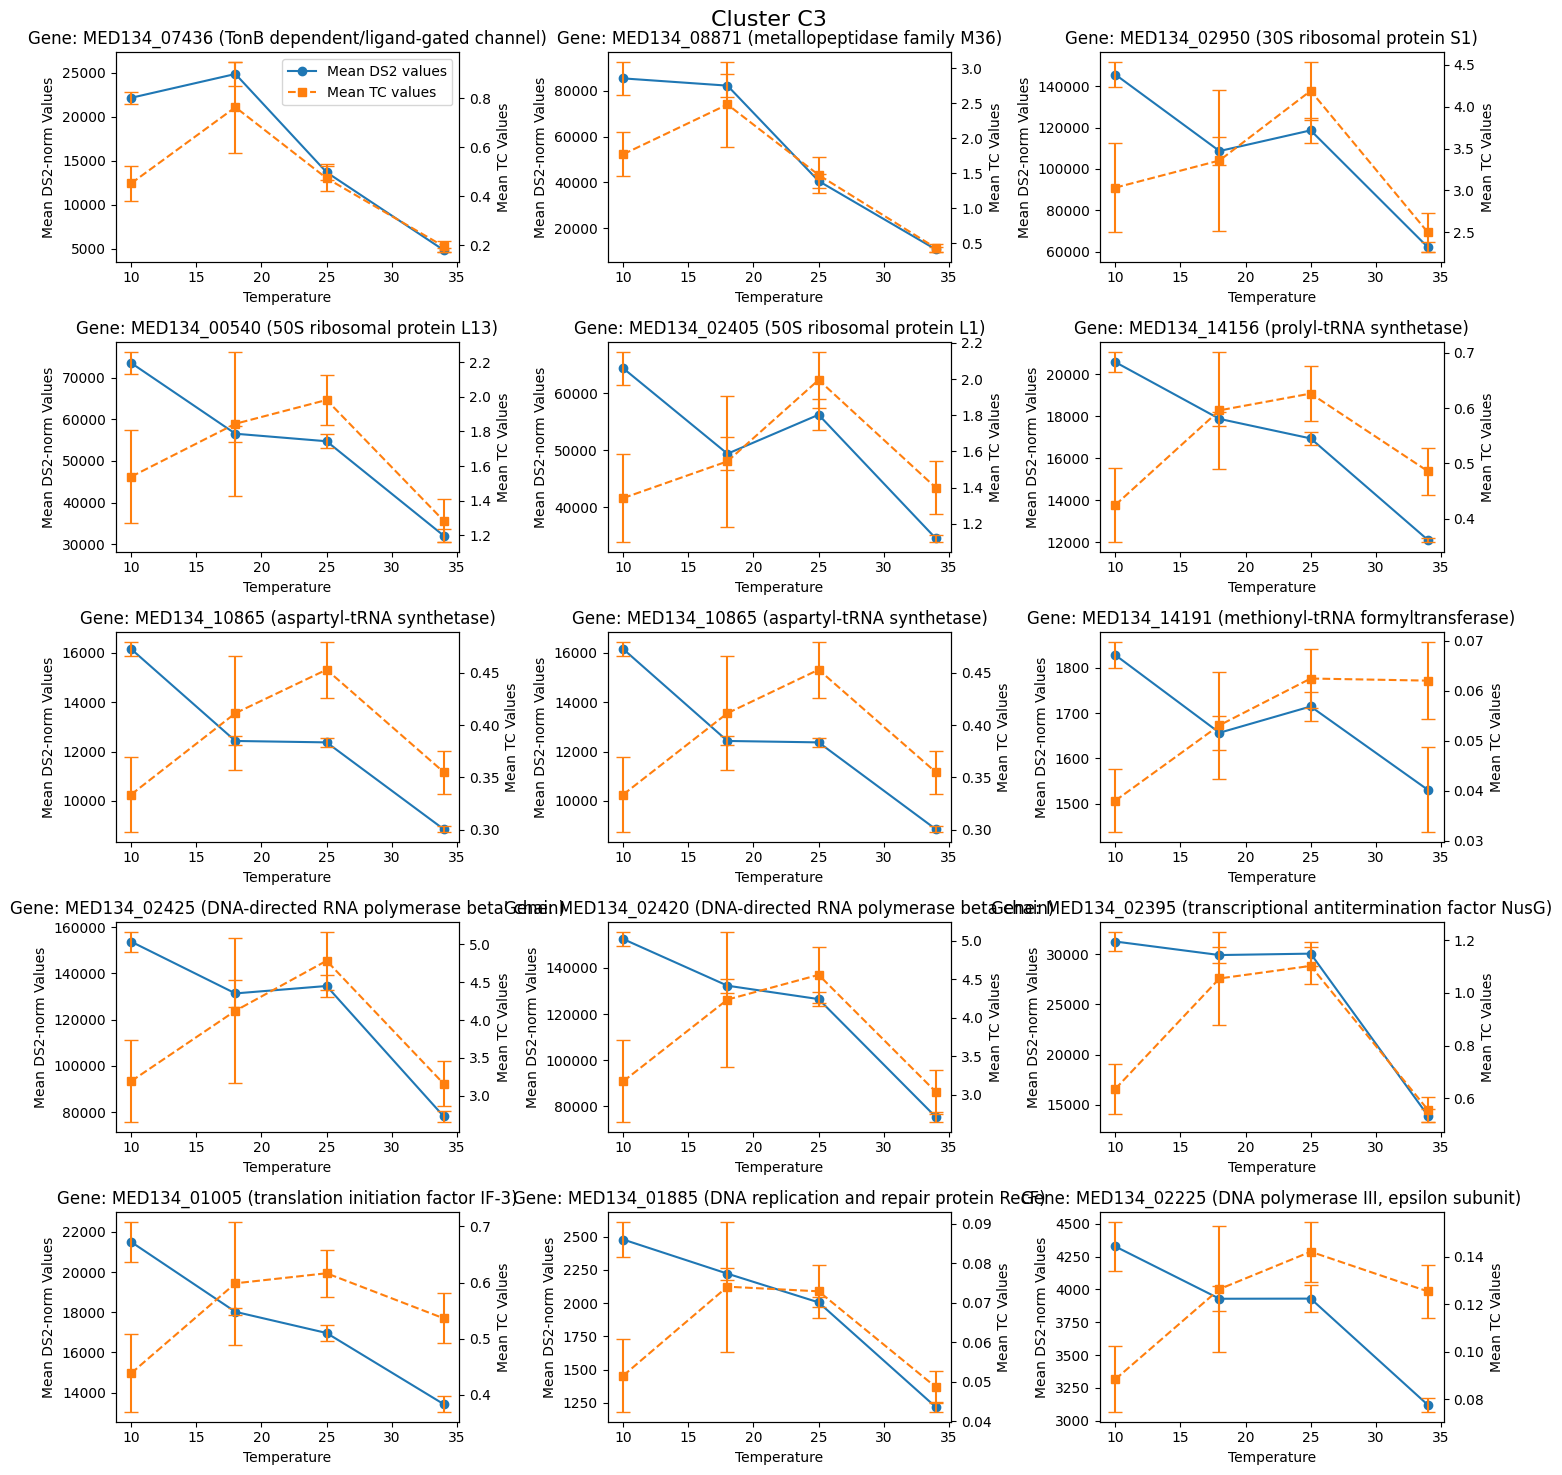

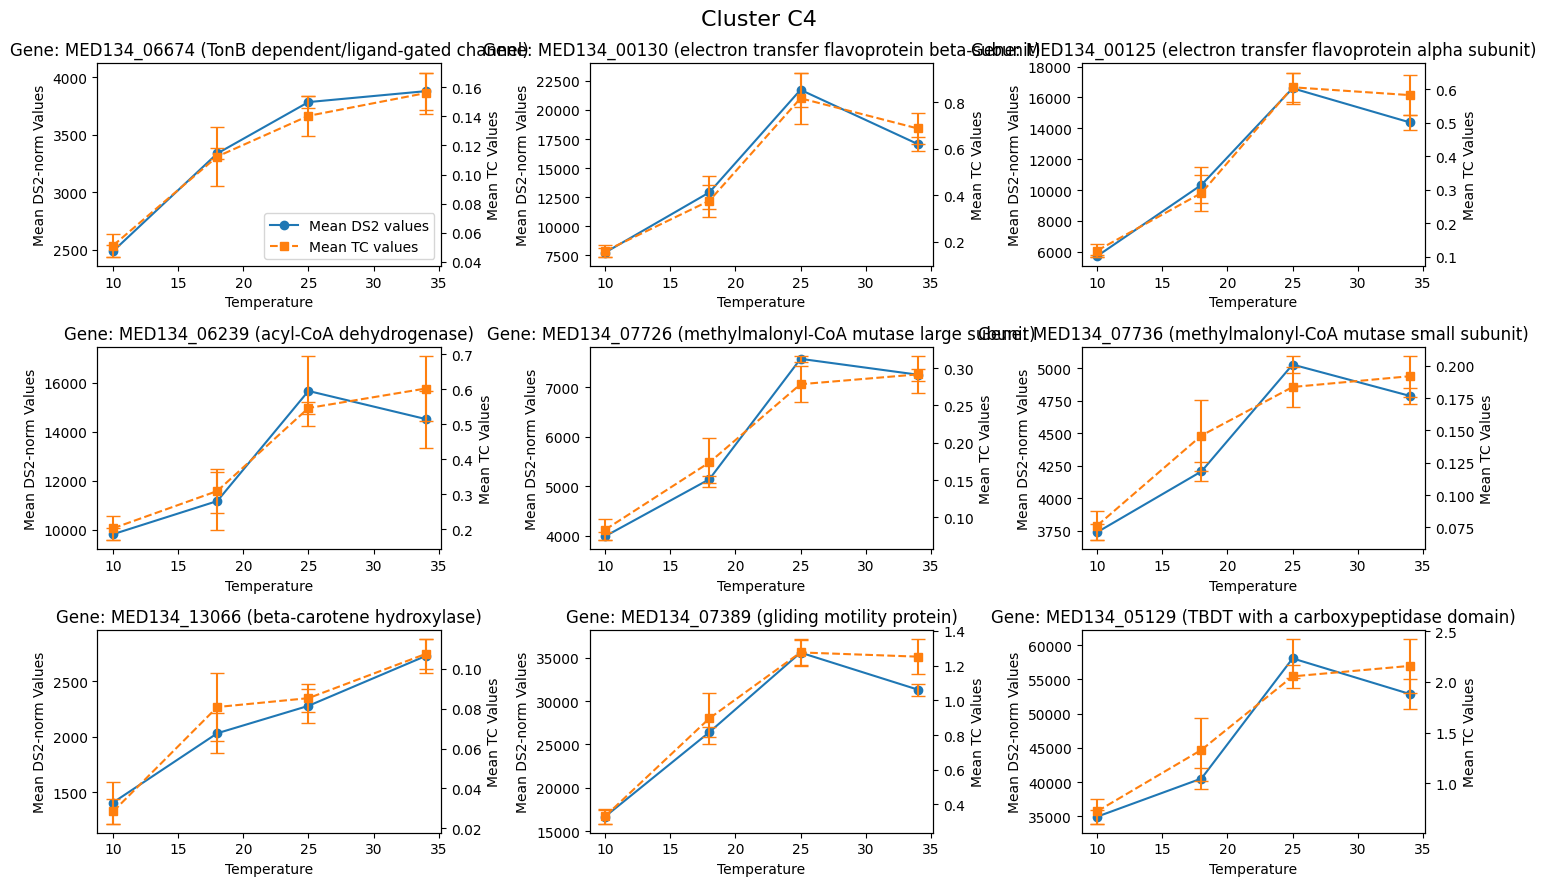

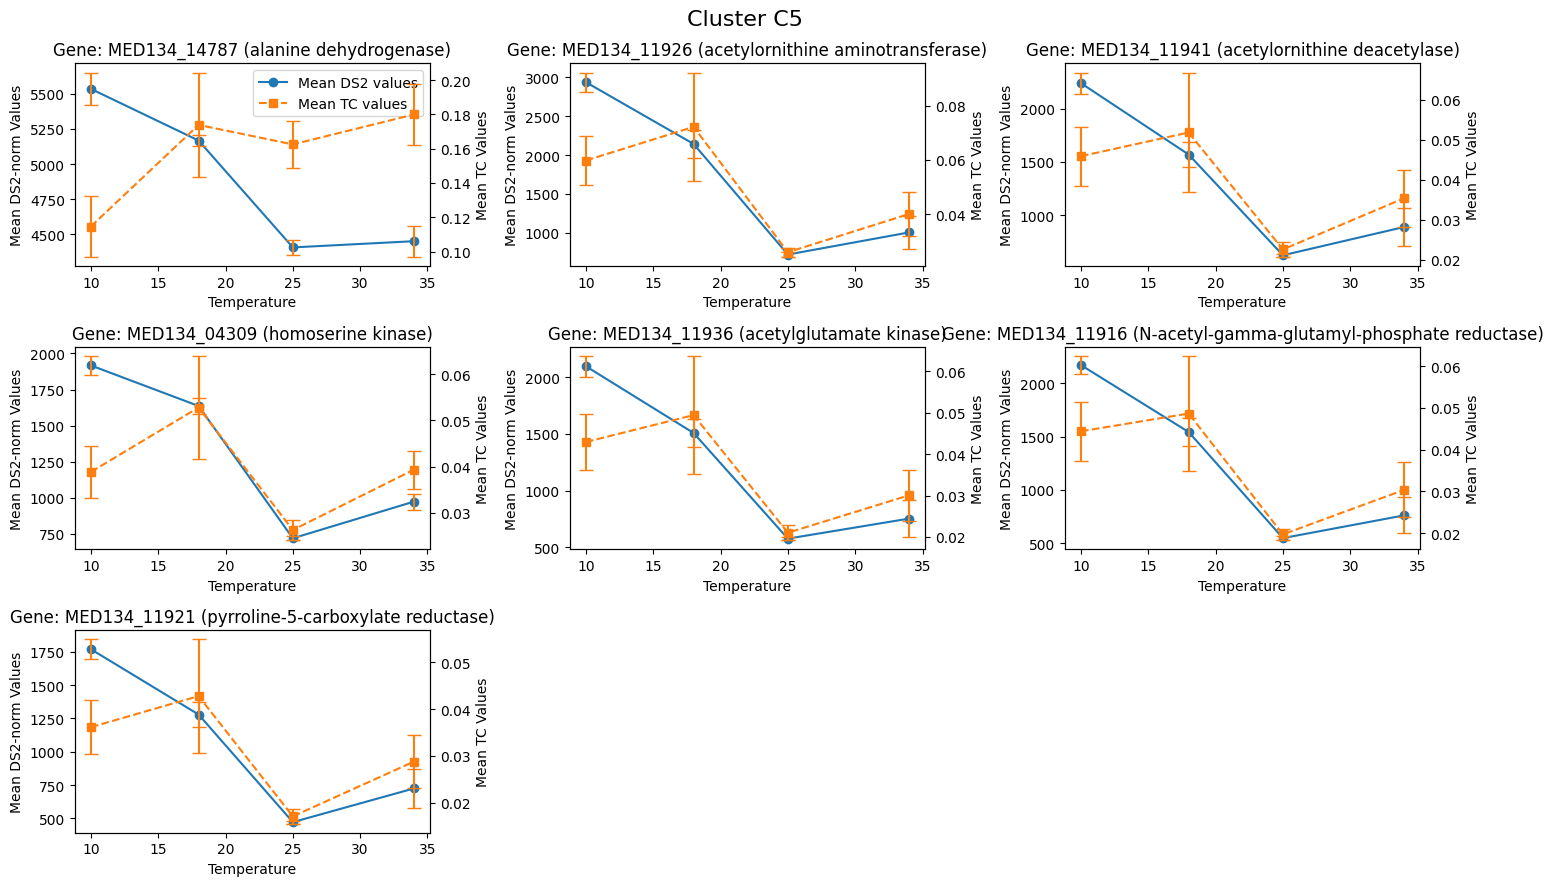

In [37]:
def plot_gene_expression(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values')
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values')
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='C1', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='C1', label='SDE TC values')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Mean DS2-norm Values')
    ax2.set_ylabel('Mean TC Values')
    ax.set_title(f'Gene: {gene_id} ({gene_name})')
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)

# Code for preprocessing the primary and secondary datasets
# Replace "TC" with the name of your second dataset
marker_genes = plot_marker_genes
target_genes = [gene[0] for cluster in marker_genes.values() for gene in cluster]

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts_noDE.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC_no18.loc[target_genes, :].reset_index().melt(id_vars='ID', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['ID', 'Temperature'])['Value']
mean_values_TC = grouped_TC.mean().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()

for cluster, genes in marker_genes.items():
    # Plotting
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['ID'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['ID'] == gene_id]
        show_legend = (idx == 0)
        plot_gene_expression(axs[idx], gene_id, gene_name, mean_values_gene, standard_error_values_gene, mean_values_gene_TC, standard_error_values_gene_TC, show_legend)

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.savefig(f'paper_figures/cluster_{cluster}_gene_expression_temperature.png')
    plt.show()
